<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **PROJETO** | Pipeline de Dados do Telegram
Projeto em parceria com a EBAC - Escola Britânica de Artes Criativas e Tecnologia

---

# 1. Introdução

Neste projeto, criamos toda uma arquitetura de ETL para capturarmos todas as mensagens de um grupo específico do Telegram criado para o projeto e retiramos Insights interessantes sobre os dados captados

Para podermos entender melhor como toda a estrutura do projeto funciona, resumidamente:

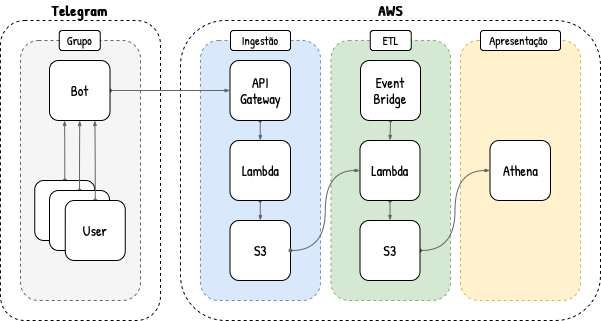

**Arquitetura**
1. Um Bot gerado no Telegram, administrador do grupo que trabalharemos, armazenará todas as mensagens de texto enviadas no grupo;
2. Utilizaremos um API Gateway criado com os serviços disponiveis da AWS para capturar os dados brutos das mensagens (em formato JSON) e posteriormente, com o serviço AWS Lambda, armazenaremos os dados brutos em um Bucket especificamente criado para isso no S3;
3. Posteriormente, com a orquestração do Event Bridge no AWS, os dados brutos capturados serão transformados para melhor entendimento e armazenados em outro Bucket no S3 especifico para isso em formato *parquet* ;
4. Com os dados transformados adequadamente, faremos a sua análise na plataforma AWS Athena usando da linguagem SQL.


**Conhecimentos aplicados**
- Gestão de APIs
- Gestão de eventos automatizados no AWS Event Bridge
- Criação de funções no AWS Lambda
- SQL
- Python
- PyArrow e *parquet*
- Gerenciamento de Buckets no AWS S3
- Analise de Dados com SQL (AWS Athena)

# 1\. Ingestão

Neste tópico, resumidamente, seguiremos fazendo a ingestão das mensagens lidas pelo Bot e salvas em sua API.
\
A cada mensagem enviada no grupo criado, temos um bot do Telegram configurado previamente para que as leia e armazene-as em sua API web no formato JSON. A Ingestão cuidará de capturar estas mensagens e redirecioná-las à um Bucket específico no **AWS S3**.
\
Para isso, criaremos uma função no **AWS Lambda** que captura cada mensagem crua na API do bot, redirecionamos a uma outra API web criada no **AWS API Gateway** e  salvamos o dado cru no Bucket `mod42-ebac-victorc-raw`.
\
\
Esta etapa é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, sem nenhuma transformação realizada em seu conteúdo ou estrutura.


No projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API *web* de *bots* do **Telegram**, portanto são fornecidos no formato JSON.
\
Como o **Telegram** retem mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada.



>**Streaming:** dados são ingeridos conforme são produzidos e disponibilizados.



Para que esse tipo de ingestão seja possível, vamos utilizar um *webhook* (gancho *web*), ou seja, vamos redirecionar as mensagens automaticamente para outra API *web*.

Como dito anteriormente, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o **AWS API Gateway**.

Dentre suas diversas funcionalidades, o **AWS API Gateway** permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao **AWS Lambda**, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do **AWS S3**.

## 1.1\. Bucket para o armazenamento de dados crus

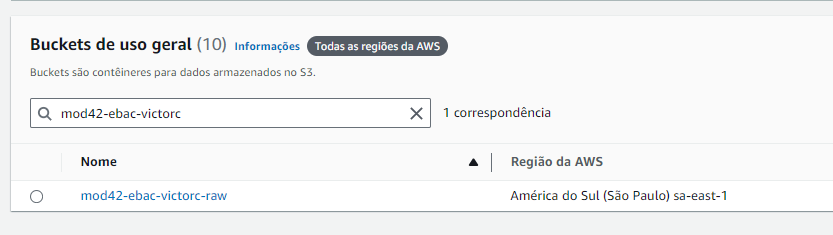

## 1.2\. Função Lambda

Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

Abaixo, código que faz todo o procedimento necessário para o armazenamento, já com as permissões necessárias no IAM e Variáveis de Ambientes definidas previamente no **AWS IAM** e **AWS Lambda**

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta
import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

## 1.3\. AWS API Gateway

Na etapa de ingestão, o **AWS API Gateway** tem a função de receber as mensagens captadas pelo bot do Telegram enviadas via *webhook*, e iniciar uma função do **AWS Lambda**, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do **AWS Lambda**:

## 1.4\. Configuração do Webhook

Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

Aqui, configuramos o *webhook* do bot através do método `setWebhook` da API de bots do Telegram. Utilizamos o endereço da API criada no **AWS API Gateway** e então o método `getWebhookInfo` para consultar a integração.
\
O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

- Aqui, armazenamos na variavel abaixo o endereço da nossa API gerada no AWS API Gateway


In [5]:
from getpass import getpass

aws_api_gateway_url = getpass()

··········


- Armazenamos o token do Bot que salva as mensagens

In [ ]:
token = getpass()

··········


In [ ]:
import requests

base_url = f'https://api.telegram.org/bot{token}'

- Confirmamos se o Webhook está configurado na linha de *description*

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


Abaixo, como exemplo, podemos observar no bucket cada mensagem crua armazenada em formato JSON no devido Bucket

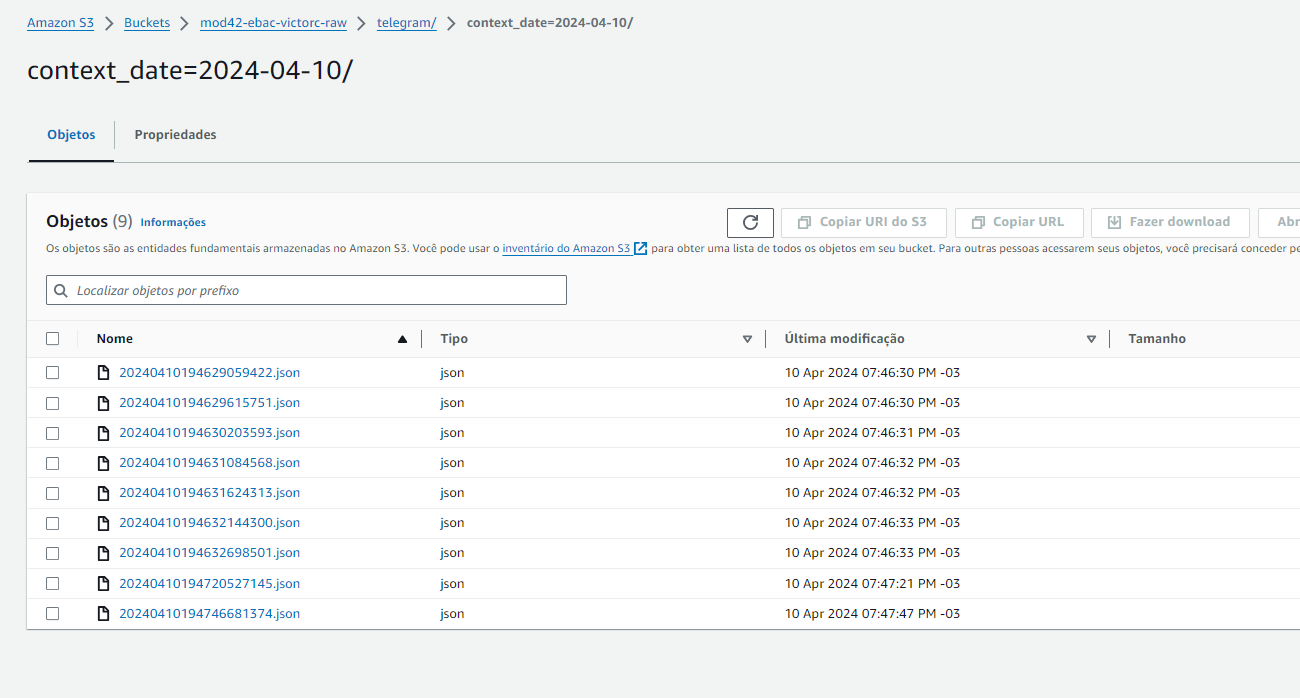

# 2\. ETL

A etapa de **extração, transformação e carregamento** (**ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos.
\
Aqui, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia persistidas na camada crua serão compactas em um único arquivo, orientado a coluna e comprimido que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vamos utilizar uma função do **AWS Lambda** como motor de processamento e um *bucket* do **AWS S3** como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do **AWS Event Bridge** como gatilho diáro da função.

## 2.1\. Bucket Enriched

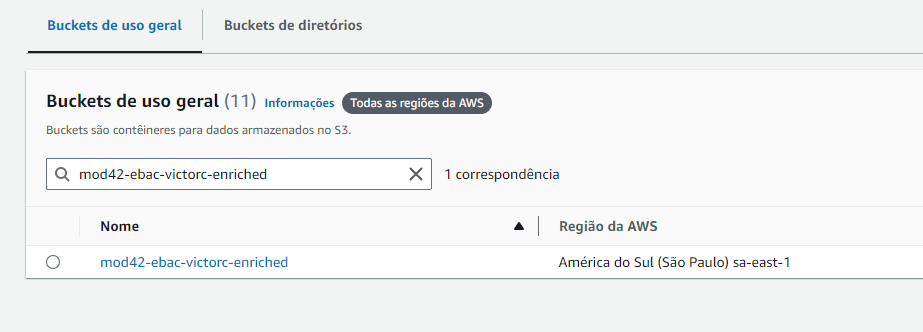

## 2.2\. Função Lambda

Na etapa de **ETL**, o **AWS Lambda** tem a função de ativamente processar as mensagens captadas pelo *bot* do Telegram, persistidas na camada crua no *bucket* do **AWS S3**, e persisti-las na camada enriquecida, também em um *bucket* do **AWS S3**. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do **AWS S3**;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do **AWS S3**.

> **Nota**: Para testar a função, alterei o codigo original:

 `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')`

 por:

 `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`

 permitindo assim o processamento de mensagens de um mesmo dia.
 \
 Agora com o projeto concluído, o segundo codigo acima estará comentado somente, sendo usado o `days=1`.

- Código da Função

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  # date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

- Código do *Data Wrangling*

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

- Retorno no AWS Lambda que o processo funcionou corretamente

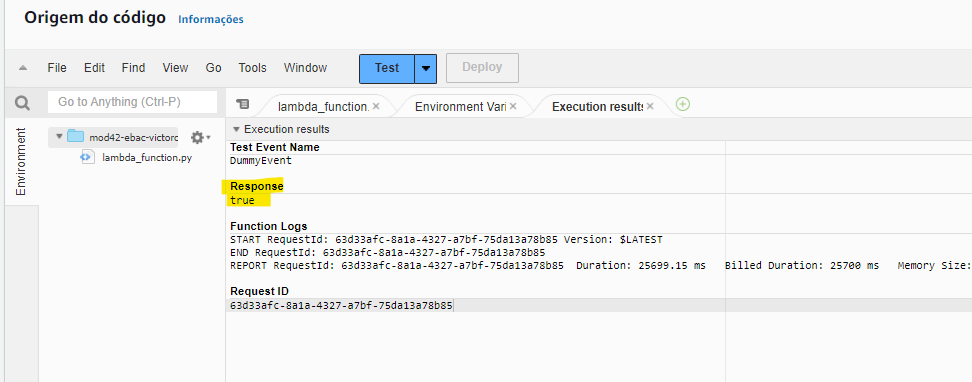

- Arquivo *parquet* gerado no bucket enriquecido

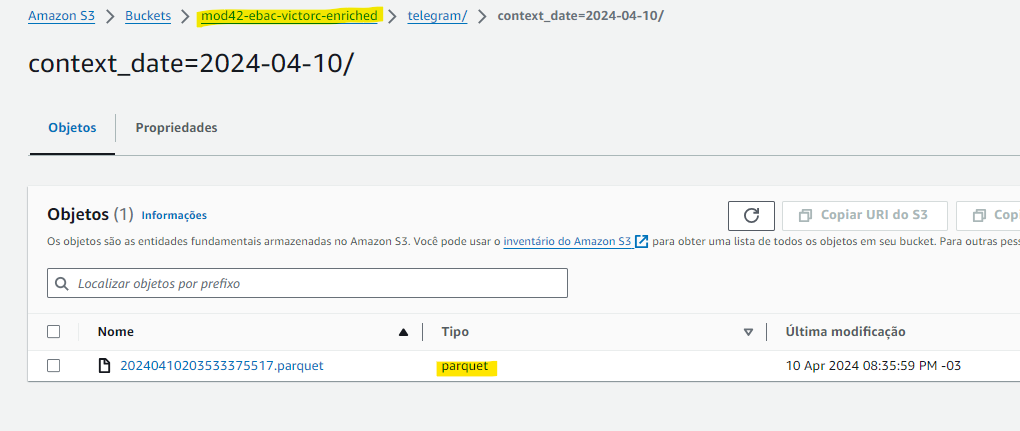

## 2.3\. Event Bridge

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

> **Nota**: Neste momento, o código da função Lambda é alterado para ler as mensagens do dia anterior, para a orquestração funcionar corretamente:
\
`date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')`

- Event Bridge configurado

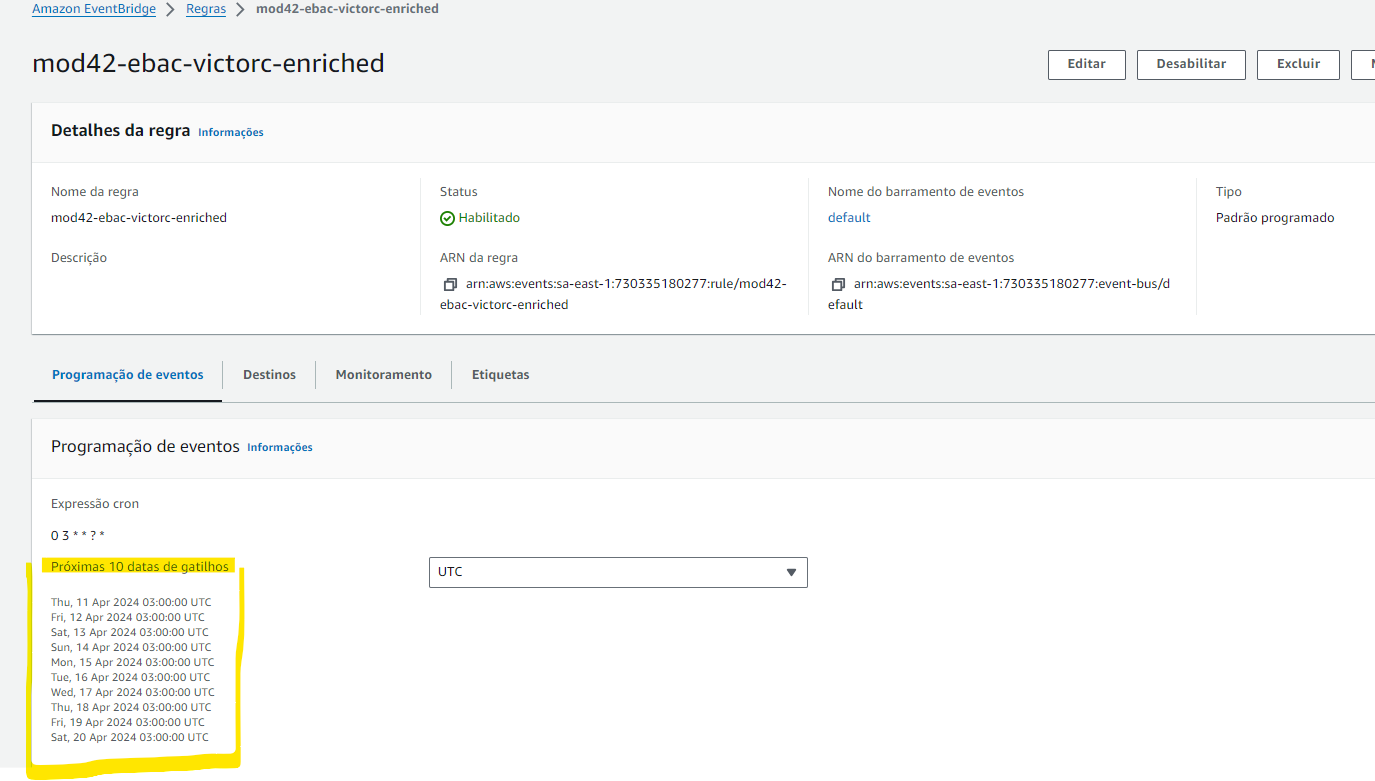

# 3\. Apresentação

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. \
Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

### **3.1. AWS Athena**

Na etapa de **apresentação**, o **AWS Athena** tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criarmos uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

Abaixo, código em SQL usado para a criação da tabela `telegram`:

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://mod42-ebac-victorc-enriched/telegram/'
```

Por fim, adicionemos as partições disponíveis:

```sql
MSCK REPAIR TABLE `telegram`;
```

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o **AWS Athena** para que a ela esteja disponível via SQL. \
\
Para isso, usamos o comando SQL para todas as partições (mais caro): \
`MSCK REPAIR TABLE <nome-tabela>` \
ou para uma única partição (mais barato). \
`ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>`  \
\
Documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

- Consulta das 10 primeiras linhas para observarmos o resultado.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

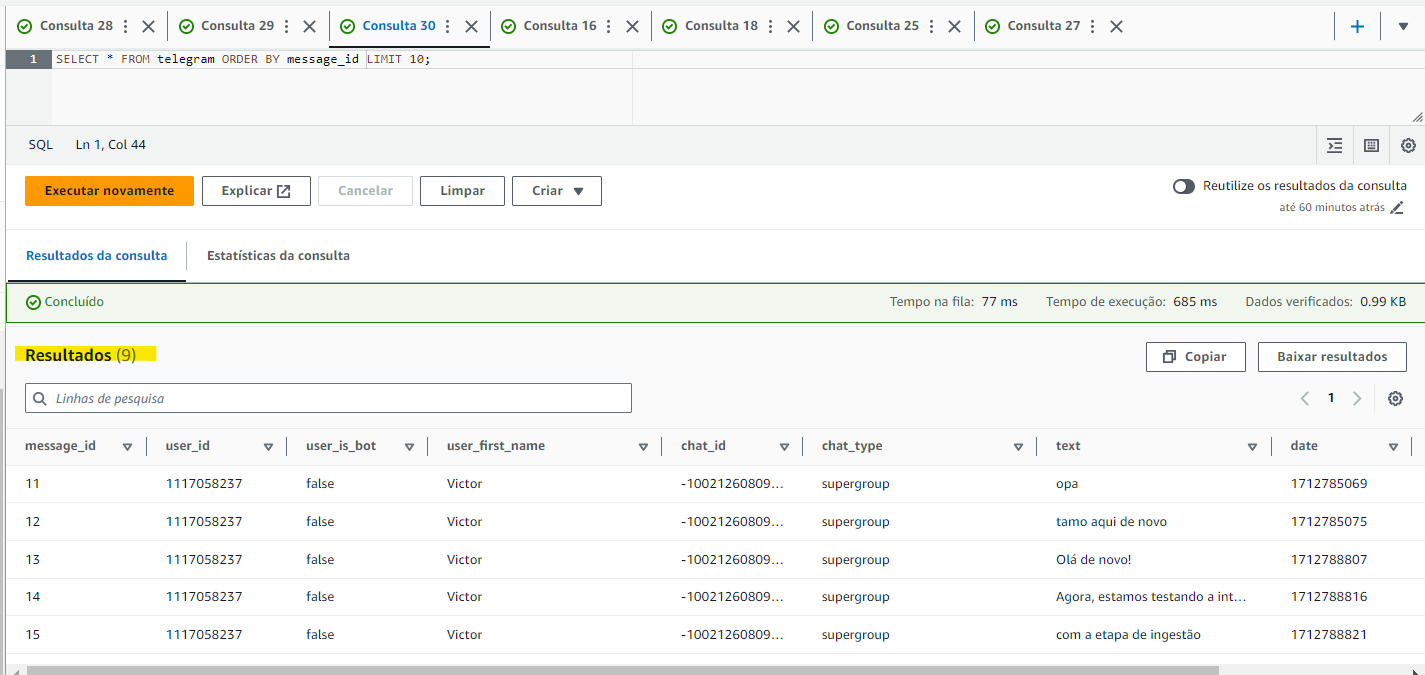

### **3.2. Analytics**

Com o dado disponível, podemos executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```
\
Resultado:

| context_date | message_ammount
|----------|----------|
| 2024-04-01 | 19 |

\

---


- Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC;
```
\
Resultado:

| user_id | user_first_name | context_date | message_ammount
|----------|-----------|----------|----------|
|1117058237| Victor | 2024-04-10 | 19 |

\

---

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```
\
Resultado:

| user_id | user_first_name | context_date | average_message_length
|----------|-----------|----------|----------|
|1117058237| Victor | 2024-04-10 | 41 |

\

---

- Quantidade de mensagens por hora por dia da semana por número da semana.

> *parsed_hour* = hora do dia; \
  *parsed_date_weekday* = dia da semana (1 = segunda-feira); \
  *parsed_date_weeknum* = numero da semana do ano;


```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```
\
Resultado:

| parsed_date_hour | parsed_date_weekday | parsed_date_weeknum | message_ammount
|----------|-----------|----------|----------|
| 22 | 3 | 15 | 7 |
| 23 | 3 | 15 | 4 |
| 21 | 3 | 15 | 2 |
| 0 | 4 | 15 | 6 |

\

---

# 4\. Storytelling

Por fim, este foi todo o nosso projeto em detalhes. iniciamos capturando cada mensagem diariamente lida pelo nosso bot no Telgram e as enviando em nosso bucket de dados crus. Após isso, fazemos o *Data Wrangling* necessário para armazenar os dados enriquecidos em formato Parquet para finalmente retirarmos insights sobre as mensagens do grupo no Telegram.
\
\
Desde manutenção de APIs, a mineração e transformação de dados brutos, até a apresentação adequada dos dados enriquecidos, trabalhamos minuciosamente para podermos retirar os seguintes insights:

Alguns insights interessantes:

- a maioria das mensagens se concentram as 22h
- até então, as mensagens capturadas foram somente de quarta-feira, no meio de Abril de 2024
- Somente 1 usuário esteve ativamente enviando mensagens
- Este usuário mantem mensagens longas, média de 41 caracteres por mensagem

Espero que tenha sido util para você, caro leitor! \
Se interessar, salve este arquivo para estudos ou o que for mais te agradar, e me contate! Será ótimo retirarmos conclusões em conjunto sobre este projeto ou nos auxiliar em dúvidas.

# Contate-me!

**victorcamolese@gmail.com** \
[**Instagram**](https://www.instagram.com/victorcamolese/#) \
[**Linkedin**](https://www.linkedin.com/in/victorcamolese/)